# Advanced AI-Driven Microbiome Analysis Platform
## Complete Working Notebook for Personalized Healthcare

This notebook provides a **complete, working implementation** of microbiome analysis to investigate neuro-disease mechanisms.

### What This Notebook Does:
1. **Installs** all required packages with compatibility fixes (no XGBoost)
2. **Imports** all necessary libraries with robust error handling
3. **Loads** the GSE113690 autism microbiome dataset (main) + ASD metadata
4. **Preprocesses** OTU abundance data with advanced taxonomy-based feature engineering
5. **Selects** optimal microbial features using statistical methods
6. **Trains** machine learning models (Random Forest, CatBoost, Logistic Regression)
7. **Generates** personalized microbiome-based healthcare recommendations
8. **Provides** comprehensive autism risk analysis results

### Dataset Information:
- **Primary**: GSE113690_Autism_16S_rRNA_OTU_assignment_and_abundance.csv
- **Format**: OTU abundance matrix with detailed taxonomic classification
- **Samples**: A* (Autism) vs B* (Control) groups
- **Features**: 16S rRNA gene sequencing data with full taxonomic hierarchy

### Algorithms Available:
- **Random Forest**: Ensemble tree-based classifier
- **CatBoost**: Gradient boosting (if available) 
- **Logistic Regression**: Linear classifier with regularization


In [27]:
# Step 1: Install Required Packages with Compatibility Handling
import subprocess
import sys
import importlib

def safe_install_package(package_name, version=None):
    """Safely install a package with proper error handling"""
    try:
        if version:
            package_spec = f"{package_name}=={version}"
        else:
            package_spec = package_name
            
        result = subprocess.run([sys.executable, "-m", "pip", "install", package_spec], 
                              capture_output=True, text=True)
        if result.returncode == 0:
            print(f"[SUCCESS] Successfully installed {package_spec}")
            return True
        else:
            print(f"[FAILED] Failed to install {package_spec}")
            return False
    except Exception as e:
        print(f"[ERROR] Error installing {package_spec}: {e}")
        return False



print("=== Installing Core Packages ===")

# Install core packages with compatible versions
core_packages = [
    ("numpy", "1.24.3"),
    ("pandas", "2.0.3"), 
    ("scipy", "1.10.1"),
    ("scikit-learn", "1.3.0"),
    ("matplotlib", "3.7.2"),
    ("seaborn", "0.12.2")
]

for package, version in core_packages:
    safe_install_package(package, version)

print("\n=== Installing Additional ML Packages ===")
additional_packages = ["catboost", "plotly", "umap-learn"]
for package in additional_packages:
    safe_install_package(package)

print("\n[COMPLETE] Package installation complete!")


=== Installing Core Packages ===
[SUCCESS] Successfully installed numpy==1.24.3
[SUCCESS] Successfully installed pandas==2.0.3
[SUCCESS] Successfully installed scipy==1.10.1
[SUCCESS] Successfully installed scikit-learn==1.3.0
[SUCCESS] Successfully installed matplotlib==3.7.2
[SUCCESS] Successfully installed seaborn==0.12.2

=== Installing Additional ML Packages ===
[SUCCESS] Successfully installed catboost
[SUCCESS] Successfully installed plotly
[SUCCESS] Successfully installed umap-learn

[COMPLETE] Package installation complete!


In [28]:
# Step 2: Import All Libraries with Robust Error Handling
import warnings
import sys
from collections import defaultdict

warnings.filterwarnings('ignore')

print("=== Importing Core Libraries ===")

# Core Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print("[SUCCESS] Core data science libraries loaded")

# Scikit-learn components - Install compatible version if needed
try:
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
    from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
    from sklearn.feature_selection import SelectKBest, f_classif
    from sklearn.linear_model import LogisticRegression
    print("[SUCCESS] Scikit-learn components loaded")
    sklearn_available = True
except ImportError as e:
    print(f"[FAILED] Scikit-learn import failed: {e}")
    print("   -> Installing compatible scikit-learn version...")
    try:
        subprocess.run([sys.executable, "-m", "pip", "install", "scikit-learn==1.3.0"], 
                      capture_output=True, text=True)
        # Try importing again
        from sklearn.model_selection import train_test_split, cross_val_score
        from sklearn.preprocessing import StandardScaler
        from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
        from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
        from sklearn.feature_selection import SelectKBest, f_classif
        from sklearn.linear_model import LogisticRegression
        print("[SUCCESS] Scikit-learn components loaded after reinstall")
        sklearn_available = True
    except Exception as e2:
        print(f"[FAILED] Scikit-learn still failing: {e2}")
        sklearn_available = False

print("\n=== Importing Advanced ML Libraries ===")

# CatBoost
CatBoostClassifier = None
try:
    from catboost import CatBoostClassifier
    print("[SUCCESS] CatBoost loaded successfully")
except ImportError:
    print("[INFO] CatBoost not available (optional)")

# Summary
available_algorithms = []
if sklearn_available:
    available_algorithms.extend(['Random Forest', 'Logistic Regression'])
if CatBoostClassifier is not None:
    available_algorithms.append('CatBoost')

print(f"\n[READY] Ready for analysis with: {', '.join(available_algorithms)}")
print(f"[INFO] Total algorithms available: {len(available_algorithms)}")


=== Importing Core Libraries ===
[SUCCESS] Core data science libraries loaded
[SUCCESS] Scikit-learn components loaded

=== Importing Advanced ML Libraries ===
[SUCCESS] CatBoost loaded successfully

[READY] Ready for analysis with: Random Forest, Logistic Regression, CatBoost
[INFO] Total algorithms available: 3


In [29]:
# Step 3: Load and Explore the Autism Microbiome Dataset
import os

print("=== Loading Autism Microbiome Dataset ===")
print("[REFERENCE] Dataset Reference: GSE113690 - Autism 16S rRNA OTU assignment and abundance")
print("[PRIMARY] Primary dataset: GSE113690_Autism_16S_rRNA_OTU_assignment_and_abundance.csv")
print("[METADATA] Metadata reference: ASD meta abundance.csv (for feature context)")
print()

# Check for available datasets (prioritize GSE113690 main dataset)
dataset_files = [
    'GSE113690_Autism_16S_rRNA_OTU_assignment_and_abundance.csv',  # Main dataset (preferred)
    'ASD meta abundance.csv'  # Metadata/alternative dataset
]

data = None
dataset_used = None

for filename in dataset_files:
    if os.path.exists(filename):
        try:
            print(f"Loading {filename}...")
            data = pd.read_csv(filename)
            dataset_used = filename
            print(f"[SUCCESS] Successfully loaded {filename}")
            break
        except Exception as e:
            print(f"[FAILED] Failed to load {filename}: {e}")
            continue

if data is None:
    print("[ERROR] No valid dataset found. Please ensure you have one of the following files:")
    for f in dataset_files:
        print(f"   - {f}")
    raise FileNotFoundError("Dataset not found")

print(f"\n[INFO] Dataset Information:")
print(f"   File: {dataset_used}")
print(f"   Shape: {data.shape}")
print(f"   Columns: {len(data.columns)}")
print(f"   Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display first few rows and basic info
print("\n[PREVIEW] Dataset Preview:")
display(data.head())

print("\n[INFO] Dataset Info:")
data.info()


=== Loading Autism Microbiome Dataset ===
[REFERENCE] Dataset Reference: GSE113690 - Autism 16S rRNA OTU assignment and abundance
[PRIMARY] Primary dataset: GSE113690_Autism_16S_rRNA_OTU_assignment_and_abundance.csv
[METADATA] Metadata reference: ASD meta abundance.csv (for feature context)

Loading GSE113690_Autism_16S_rRNA_OTU_assignment_and_abundance.csv...
[SUCCESS] Successfully loaded GSE113690_Autism_16S_rRNA_OTU_assignment_and_abundance.csv

[INFO] Dataset Information:
   File: GSE113690_Autism_16S_rRNA_OTU_assignment_and_abundance.csv
   Shape: (1322, 256)
   Columns: 256
   Memory usage: 2.9 MB

[PREVIEW] Dataset Preview:


,OTU,taxonomy,A1,A10,A100,A101,A102,A104,A105,A106,...,B52,B54,B55,B56,B57,B58,B59,B6,B60,B61
0,OTU1,d__Bacteria;_k__norank;_p__Firmicutes;_c__Clos...,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,OTU2,d__Bacteria;_k__norank;_p__Proteobacteria;_c__...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,OTU3,d__Bacteria;_k__norank;_p__Firmicutes;_c__Erys...,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
3,OTU4,d__Bacteria;_k__norank;_p__Firmicutes;_c__Baci...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,OTU5,d__Bacteria;_k__norank;_p__Tenericutes;_c__Mol...,0,0,1,0,0,1,0,3,...,0,0,0,0,0,0,0,0,0,0



[INFO] Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1322 entries, 0 to 1321
Columns: 256 entries, OTU to B61
dtypes: int64(254), object(2)
memory usage: 2.6+ MB


In [30]:
# Step 4a: Examine Data Structure
print("=== Examining Data Structure ===")

print(f"[INFO] Dataset shape: {data.shape}")
print(f"[INFO] First few columns: {list(data.columns[:10])}")
print(f"[INFO] Last few columns: {list(data.columns[-10:])}")

# Check for sample naming patterns
sample_cols = [col for col in data.columns if col not in ['OTU', 'taxonomy', 'Taxonomy']]
a_samples = [col for col in sample_cols if col.startswith('A')]
b_samples = [col for col in sample_cols if col.startswith('B')]

print(f"\n[ANALYSIS] Sample Analysis:")
print(f"   A-samples (likely Autism): {len(a_samples)} samples")
print(f"   B-samples (likely Control): {len(b_samples)} samples") 
print(f"   Example A-samples: {a_samples[:5]}")
print(f"   Example B-samples: {b_samples[:5]}")

# Show data structure
print(f"\n[PREVIEW] Data Preview:")
print("First 3 rows, first 8 columns:")
display(data.iloc[:3, :8])

if 'OTU' in data.columns and 'taxonomy' in data.columns:
    print(f"\n[FORMAT] GSE113690 Dataset Format:")
    print(f"   [INFO] Total OTUs: {len(data)}")
    print(f"   [INFO] Example OTU IDs: {data['OTU'].head(3).tolist()}")
    print(f"   [INFO] Taxonomy Examples (GSE113690 format):")
    taxonomy_examples = data['taxonomy'].head(3).tolist()
    for i, tax in enumerate(taxonomy_examples, 1):
        # Truncate long taxonomy strings for display
        tax_display = tax[:80] + "..." if len(tax) > 80 else tax
        print(f"   {i}. {tax_display}")
elif 'Taxonomy' in data.columns:
    print(f"\n[FORMAT] Taxonomy Examples (Kaggle format):")
    taxonomy_examples = data['Taxonomy'].head(3).tolist()
    for i, tax in enumerate(taxonomy_examples, 1):
        print(f"   {i}. {tax}")
    print(f"   [INFO] Total bacterial species/OTUs: {len(data)}")
elif 'taxonomy' in data.columns:
    print(f"\n[FORMAT] Taxonomy Examples:")
    print(data['taxonomy'].head(3).tolist())


=== Examining Data Structure ===
[INFO] Dataset shape: (1322, 256)
[INFO] First few columns: ['OTU', 'taxonomy', 'A1', 'A10', 'A100', 'A101', 'A102', 'A104', 'A105', 'A106']
[INFO] Last few columns: ['B52', 'B54', 'B55', 'B56', 'B57', 'B58', 'B59', 'B6', 'B60', 'B61']

[ANALYSIS] Sample Analysis:
   A-samples (likely Autism): 143 samples
   B-samples (likely Control): 111 samples
   Example A-samples: ['A1', 'A10', 'A100', 'A101', 'A102']
   Example B-samples: ['B1', 'B10', 'B100', 'B101', 'B103']

[PREVIEW] Data Preview:
First 3 rows, first 8 columns:


,OTU,taxonomy,A1,A10,A100,A101,A102,A104
0,OTU1,d__Bacteria;_k__norank;_p__Firmicutes;_c__Clos...,0,0,0,0,0,0
1,OTU2,d__Bacteria;_k__norank;_p__Proteobacteria;_c__...,0,0,0,0,0,0
2,OTU3,d__Bacteria;_k__norank;_p__Firmicutes;_c__Erys...,0,0,0,0,0,0



[FORMAT] GSE113690 Dataset Format:
   [INFO] Total OTUs: 1322
   [INFO] Example OTU IDs: ['OTU1', 'OTU2', 'OTU3']
   [INFO] Taxonomy Examples (GSE113690 format):
   1. d__Bacteria;_k__norank;_p__Firmicutes;_c__Clostridia;_o__Clostridiales;_f__Deflu...
   2. d__Bacteria;_k__norank;_p__Proteobacteria;_c__Alphaproteobacteria;_o__Sphingomon...
   3. d__Bacteria;_k__norank;_p__Firmicutes;_c__Erysipelotrichia;_o__Erysipelotrichale...


In [31]:
# Step 4c: Validate Dataset Format
print("=== Validating Dataset Format ===")

checks_passed = 0
total_checks = 6

if dataset_used == 'GSE113690_Autism_16S_rRNA_OTU_assignment_and_abundance.csv':
    print("[SUCCESS] Using GSE113690 main dataset")
    
    # Check 1: OTU column exists
    if 'OTU' in data.columns:
        print("[PASS] OTU column found")
        checks_passed += 1
    else:
        print("[FAIL] OTU column missing")
    
    # Check 2: taxonomy column exists
    if 'taxonomy' in data.columns:
        print("[PASS] taxonomy column found")
        checks_passed += 1
    else:
        print("[FAIL] taxonomy column missing")
    
    # Check 3: A and B sample patterns
    a_count = len([col for col in data.columns if col.startswith('A')])
    b_count = len([col for col in data.columns if col.startswith('B')])
    if a_count > 0 and b_count > 0:
        print(f"[PASS] Sample naming pattern correct: {a_count} A-samples, {b_count} B-samples")
        checks_passed += 1
    else:
        print("[FAIL] Sample naming pattern incorrect")
    
    # Check 4: Taxonomy format validation (GSE113690 format)
    if 'taxonomy' in data.columns:
        sample_taxonomy = data['taxonomy'].iloc[0]
        if 'd__' in str(sample_taxonomy) and 'p__' in str(sample_taxonomy) and ';' in str(sample_taxonomy):
            print("[PASS] Taxonomy format is correct (d__Domain;p__Phylum;c__Class format)")
            checks_passed += 1
        else:
            print("[FAIL] Taxonomy format unexpected")
    
    # Check 5: Numeric abundance values
    sample_cols = [col for col in data.columns if col.startswith(('A', 'B'))]
    if len(sample_cols) > 0:
        numeric_check = pd.api.types.is_numeric_dtype(data[sample_cols[0]])
        if numeric_check:
            print("[PASS] Abundance values are numeric")
            checks_passed += 1
        else:
            print("[FAIL] Abundance values are not numeric")
    
    # Check 6: Reasonable data dimensions
    if data.shape[0] > 100 and data.shape[1] > 10:
        print(f"[PASS] Dataset dimensions reasonable: {data.shape[0]} OTUs × {data.shape[1]} total columns")
        checks_passed += 1
    else:
        print("[FAIL] Dataset dimensions seem too small")

elif dataset_used == 'ASD meta abundance.csv':
    print("[SUCCESS] Using ASD meta abundance dataset")
    total_checks = 5  # Different number of checks for this format
    
    # Check 1: Taxonomy column exists
    if 'Taxonomy' in data.columns:
        print("[PASS] Taxonomy column found")
        checks_passed += 1
    else:
        print("[FAIL] Taxonomy column missing")
    
    # Check 2: A and B sample patterns
    a_count = len([col for col in data.columns if col.startswith('A')])
    b_count = len([col for col in data.columns if col.startswith('B')])
    if a_count > 0 and b_count > 0:
        print(f"[PASS] Sample naming pattern correct: {a_count} A-samples, {b_count} B-samples")
        checks_passed += 1
    else:
        print("[FAIL] Sample naming pattern incorrect")
    
    # Check 3: Taxonomy format validation (Kaggle format)
    if 'Taxonomy' in data.columns:
        sample_taxonomy = data['Taxonomy'].iloc[0]
        if 'g__' in str(sample_taxonomy) and ';' in str(sample_taxonomy):
            print("[PASS] Taxonomy format is correct (g__Genus;s__Species)")
            checks_passed += 1
        else:
            print("[FAIL] Taxonomy format unexpected")
    
    # Check 4: Numeric abundance values
    sample_cols = [col for col in data.columns if col.startswith(('A', 'B'))]
    if len(sample_cols) > 0:
        numeric_check = pd.api.types.is_numeric_dtype(data[sample_cols[0]])
        if numeric_check:
            print("[PASS] Abundance values are numeric")
            checks_passed += 1
        else:
            print("[FAIL] Abundance values are not numeric")
    
    # Check 5: Reasonable data dimensions
    if data.shape[0] > 100 and data.shape[1] > 10:
        print(f"[PASS] Dataset dimensions reasonable: {data.shape[0]} species × {data.shape[1]} total columns")
        checks_passed += 1
    else:
        print("[FAIL] Dataset dimensions seem too small")

else:
    print(f"[INFO] Using unknown dataset: {dataset_used}")
    print("   Validation designed for GSE113690 and ASD meta abundance formats")

print(f"\n[SUMMARY] Validation Summary: {checks_passed}/{total_checks} checks passed")

if checks_passed >= (total_checks - 1):
    print("[SUCCESS] Dataset format is valid for analysis!")
else:
    print("[WARNING] Dataset format may have issues - proceeding with caution")

print("\n" + "="*50)


=== Validating Dataset Format ===
[SUCCESS] Using GSE113690 main dataset
[PASS] OTU column found
[PASS] taxonomy column found
[PASS] Sample naming pattern correct: 143 A-samples, 111 B-samples
[PASS] Taxonomy format is correct (d__Domain;p__Phylum;c__Class format)
[PASS] Abundance values are numeric
[PASS] Dataset dimensions reasonable: 1322 OTUs × 256 total columns

[SUMMARY] Validation Summary: 6/6 checks passed
[SUCCESS] Dataset format is valid for analysis!



In [32]:
# Step 4d: Data Preprocessing and Feature Engineering
print("=== Data Preprocessing Pipeline ===")

def prepare_microbiome_data(df):
    """Prepare microbiome data for machine learning"""
    print("[PROCESS] Starting data preparation...")
    
    # Check data structure - this looks like a typical microbiome abundance matrix
    print(f"   Original data shape: {df.shape}")
    print(f"   Columns: {list(df.columns[:5])}... (showing first 5)")
    
    # Identify sample columns (exclude taxonomy/metadata columns)
    non_sample_cols = ['OTU', 'taxonomy', 'otu', 'Taxonomy', 'OTU_ID', 'otu_id', 'Taxa', 'taxa']
    sample_columns = [col for col in df.columns if col not in non_sample_cols]
    
    print(f"[SUCCESS] Identified {len(sample_columns)} sample columns")
    
    # Create feature matrix (transpose so samples are rows, OTUs are columns)
    # Use only numeric sample columns
    numeric_sample_cols = []
    for col in sample_columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            numeric_sample_cols.append(col)
    
    if len(numeric_sample_cols) == 0:
        print("[ERROR] No numeric sample columns found")
        return None, None, None
    
    print(f"[SUCCESS] Found {len(numeric_sample_cols)} numeric sample columns")
    
    # Transpose the abundance data
    X = df[numeric_sample_cols].T  # Transpose: samples as rows, OTUs as columns
    X.index = numeric_sample_cols  # Sample IDs as row names
    
    # Create feature names from taxonomy information
    if 'OTU' in df.columns and 'taxonomy' in df.columns:
        # Handle GSE113690 format with OTU and taxonomy columns
        feature_names = []
        for i, row in df.iterrows():
            otu_id = str(row['OTU']) if pd.notna(row['OTU']) else f"OTU_{i}"
            taxonomy = str(row['taxonomy']) if pd.notna(row['taxonomy']) else "Unknown"
            
            # Parse GSE113690 taxonomy format: d__Domain;_k__Kingdom;_p__Phylum;_c__Class;_o__Order;_f__Family;_g__Genus;_s__Species
            tax_parts = taxonomy.split(';')
            
            genus = "Unknown_genus"
            species = "Unknown_species"
            family = "Unknown_family"
            
            for part in tax_parts:
                part = part.strip()
                if part.startswith('_g__'):
                    genus = part.replace('_g__', '').strip()
                elif part.startswith('_s__'):
                    species = part.replace('_s__', '').strip()
                elif part.startswith('_f__'):
                    family = part.replace('_f__', '').strip()
            
            # Create clean feature name
            if species != "Unknown_species" and species != "" and not species.startswith('unclassified') and not species.startswith('uncultured'):
                # Use species if available and meaningful
                feature_name = f"{otu_id}_{genus}_{species}".replace(' ', '_')
            elif genus != "Unknown_genus" and genus != "" and not genus.startswith('norank'):
                # Use genus if species not available
                feature_name = f"{otu_id}_{genus}_sp".replace(' ', '_')
            elif family != "Unknown_family" and family != "" and not family.startswith('norank'):
                # Fall back to family level
                feature_name = f"{otu_id}_{family}_family".replace(' ', '_')
            else:
                # Just use OTU ID
                feature_name = f"{otu_id}"
            
            # Clean up the name
            feature_name = feature_name.replace('__', '_').replace('norank_', '').replace('unclassified_', '')
            
            # Make sure feature names are unique
            base_name = feature_name
            counter = 1
            while feature_name in feature_names:
                feature_name = f"{base_name}_{counter}"
                counter += 1
            
            feature_names.append(feature_name)
        
        X.columns = feature_names
        
    elif 'Taxonomy' in df.columns:
        # Handle ASD meta abundance format with single Taxonomy column
        feature_names = []
        for i, row in df.iterrows():
            taxonomy = str(row['Taxonomy']) if pd.notna(row['Taxonomy']) else f"Unknown_{i}"
            # Extract genus and species from taxonomy string
            # Format: g__Genus;s__Species
            tax_parts = taxonomy.split(';')
            
            genus = "Unknown_genus"
            species = "Unknown_species"
            
            for part in tax_parts:
                if part.startswith('g__'):
                    genus = part.replace('g__', '').strip()
                elif part.startswith('s__'):
                    species = part.replace('s__', '').strip()
            
            # Create clean feature name
            if species != "Unknown_species" and species != "":
                feature_name = f"{genus}_{species}".replace(' ', '_')
            else:
                feature_name = f"{genus}_sp".replace(' ', '_')
            
            # Make sure feature names are unique
            base_name = feature_name
            counter = 1
            while feature_name in feature_names:
                feature_name = f"{base_name}_{counter}"
                counter += 1
            
            feature_names.append(feature_name)
        
        X.columns = feature_names
        
    elif 'OTU' in df.columns:
        X.columns = [f"OTU_{otu}" for otu in df['OTU']]
    else:
        X.columns = [f"Feature_{i}" for i in range(X.shape[1])]
    
    print(f"[SUCCESS] Created feature matrix: {X.shape[0]} samples × {X.shape[1]} features")
    
    # Create target variable based on sample naming convention
    # A* samples = Autism (1), B* samples = Control (0)
    y = pd.Series(index=X.index, dtype=int)
    
    autism_count = 0
    control_count = 0
    
    for sample_id in X.index:
        if str(sample_id).startswith('A'):
            y[sample_id] = 1  # Autism
            autism_count += 1
        elif str(sample_id).startswith('B'):
            y[sample_id] = 0  # Control  
            control_count += 1
        else:
            # Handle other naming conventions
            print(f"[WARNING] Unknown sample naming: {sample_id}")
            y[sample_id] = -1  # Mark as unknown
    
    # Remove unknown samples
    known_samples = y != -1
    X = X[known_samples]
    y = y[known_samples]
    
    print(f"[SUCCESS] Target variable created:")
    print(f"   Autism samples (A*): {autism_count}")
    print(f"   Control samples (B*): {control_count}")
    print(f"   Total samples: {len(y)}")
    
    # Handle missing values
    X = X.fillna(0)  # Fill missing abundance values with 0
    print(f"[SUCCESS] Filled missing values with 0")
    
    # Remove low-variance features (OTUs with very little variation)
    initial_features = X.shape[1]
    variance_threshold = 0.001
    feature_variances = X.var()
    high_variance_features = feature_variances[feature_variances > variance_threshold].index
    X = X[high_variance_features]
    
    print(f"[SUCCESS] Removed {initial_features - X.shape[1]} low-variance features")
    print(f"[SUCCESS] Final dataset: {X.shape[0]} samples, {X.shape[1]} features")
    print(f"[SUCCESS] Target distribution: Autism={sum(y==1)}, Control={sum(y==0)}")
    
    return X, y, list(X.columns)

# Prepare the data
X, y, feature_names = prepare_microbiome_data(data)

if X is not None:
    print("\n[COMPLETE] Data preparation successful!")
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
else:
    print("[ERROR] Data preparation failed")


=== Data Preprocessing Pipeline ===
[PROCESS] Starting data preparation...
   Original data shape: (1322, 256)
   Columns: ['OTU', 'taxonomy', 'A1', 'A10', 'A100']... (showing first 5)
[SUCCESS] Identified 254 sample columns
[SUCCESS] Found 254 numeric sample columns
[SUCCESS] Created feature matrix: 254 samples × 1322 features
[SUCCESS] Target variable created:
   Autism samples (A*): 143
   Control samples (B*): 111
   Total samples: 254
[SUCCESS] Filled missing values with 0
[SUCCESS] Removed 7 low-variance features
[SUCCESS] Final dataset: 254 samples, 1315 features
[SUCCESS] Target distribution: Autism=143, Control=111

[COMPLETE] Data preparation successful!
Features shape: (254, 1315)
Target shape: (254,)


In [33]:
# Step 5: Feature Selection and Data Splitting
print("=== Feature Selection and Data Splitting ===")

if X is not None and y is not None:
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"[SUCCESS] Data split complete:")
    print(f"   Training: {X_train.shape[0]} samples")
    print(f"   Testing: {X_test.shape[0]} samples")
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("[SUCCESS] Feature scaling applied")
    
    # Feature selection using statistical tests
    n_features_to_select = min(50, X_train.shape[1])  # Select top 50 or all if less
    
    selector = SelectKBest(score_func=f_classif, k=n_features_to_select)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    # Get selected feature names
    selected_indices = selector.get_support(indices=True)
    selected_features = [X.columns[i] for i in selected_indices]
    
    print(f"[SUCCESS] Feature selection complete: {len(selected_features)} features selected")
    print(f"   Selected features shape: {X_train_selected.shape}")
    
    # Display top 10 selected features
    feature_scores = selector.scores_[selected_indices]
    feature_importance = list(zip(selected_features, feature_scores))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    print("\n[TOP FEATURES] Top 10 Most Important Features:")
    for i, (feature, score) in enumerate(feature_importance[:10]):
        print(f"   {i+1:2d}. {feature}: {score:.3f}")
        
else:
    print("[ERROR] Cannot proceed without valid data")


=== Feature Selection and Data Splitting ===
[SUCCESS] Data split complete:
   Training: 203 samples
   Testing: 51 samples
[SUCCESS] Feature scaling applied
[SUCCESS] Feature selection complete: 50 features selected
   Selected features shape: (203, 50)

[TOP FEATURES] Top 10 Most Important Features:
    1. OTU1253_Ruminococcaceae_UCG-014_sp: 49.767
    2. OTU784_[Eubacterium]_xylanophilum_group_sp: 42.755
    3. OTU628_Ruminiclostridium_6_[Eubacterium]_siraeum_DSM_15702: 35.275
    4. OTU813_Christensenellaceae_R-7_group_sp: 31.625
    5. OTU241_Christensenellaceae_R-7_group_sp: 30.133
    6. OTU800_Lachnospiraceae_family: 27.236
    7. OTU397_Vulcaniibacterium_sp: 25.910
    8. OTU1146_Blautia_Ruminococcus_sp._DJF_VR70k1: 25.113
    9. OTU970_Ruminiclostridium_6_sp: 23.462
   10. OTU538_Thermus_Thermus_scotoductus: 21.309


In [34]:
# Step 6: Machine Learning Model Training and Evaluation
print("=== Machine Learning Model Training ===")

if 'X_train_selected' in locals() and sklearn_available:
    results = {}
    models = {}
    
    # Random Forest
    print("\n[RF] Training Random Forest...")
    try:
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
        rf_model.fit(X_train_selected, y_train)
        rf_pred = rf_model.predict(X_test_selected)
        rf_prob = rf_model.predict_proba(X_test_selected)[:, 1]
        
        rf_accuracy = accuracy_score(y_test, rf_pred)
        rf_auc = roc_auc_score(y_test, rf_prob)
        
        results['Random Forest'] = {'accuracy': rf_accuracy, 'auc': rf_auc}
        models['Random Forest'] = rf_model
        print(f"   [SUCCESS] Accuracy: {rf_accuracy:.3f}, AUC: {rf_auc:.3f}")
    except Exception as e:
        print(f"   [FAILED] Random Forest training failed: {e}")
    
    # CatBoost (if available)
    if CatBoostClassifier is not None:
        print("\n[CATBOOST] Training CatBoost...")
        try:
            cat_model = CatBoostClassifier(iterations=100, random_state=42, verbose=False)
            cat_model.fit(X_train_selected, y_train)
            cat_pred = cat_model.predict(X_test_selected)
            cat_prob = cat_model.predict_proba(X_test_selected)[:, 1]
            
            cat_accuracy = accuracy_score(y_test, cat_pred)
            cat_auc = roc_auc_score(y_test, cat_prob)
            
            results['CatBoost'] = {'accuracy': cat_accuracy, 'auc': cat_auc}
            models['CatBoost'] = cat_model
            print(f"   [SUCCESS] Accuracy: {cat_accuracy:.3f}, AUC: {cat_auc:.3f}")
        except Exception as e:
            print(f"   [FAILED] CatBoost training failed: {e}")
    
    # Logistic Regression
    print("\n[LR] Training Logistic Regression...")
    try:
        lr_model = LogisticRegression(random_state=42, max_iter=1000)
        lr_model.fit(X_train_selected, y_train)
        lr_pred = lr_model.predict(X_test_selected)
        lr_prob = lr_model.predict_proba(X_test_selected)[:, 1]
        
        lr_accuracy = accuracy_score(y_test, lr_pred)
        lr_auc = roc_auc_score(y_test, lr_prob)
        
        results['Logistic Regression'] = {'accuracy': lr_accuracy, 'auc': lr_auc}
        models['Logistic Regression'] = lr_model
        print(f"   [SUCCESS] Accuracy: {lr_accuracy:.3f}, AUC: {lr_auc:.3f}")
    except Exception as e:
        print(f"   [FAILED] Logistic Regression training failed: {e}")
    
    # Results summary
    if results:
        print("\n[SUMMARY] Model Performance Summary:")
        print("=" * 50)
        results_df = pd.DataFrame(results).T
        results_df = results_df.sort_values('auc', ascending=False)
        
        for model_name, metrics in results_df.iterrows():
            print(f"{model_name:20s} | Accuracy: {metrics['accuracy']:.3f} | AUC: {metrics['auc']:.3f}")
        
        # Best model
        best_model_name = results_df.index[0]
        best_model = models[best_model_name]
        print(f"\n[BEST] Best performing model: {best_model_name}")
    else:
        print("[ERROR] No models trained successfully")
    
else:
    print("[ERROR] Cannot train models without processed data or scikit-learn")


=== Machine Learning Model Training ===

[RF] Training Random Forest...
   [SUCCESS] Accuracy: 0.804, AUC: 0.904

[CATBOOST] Training CatBoost...
   [SUCCESS] Accuracy: 0.784, AUC: 0.923

[LR] Training Logistic Regression...
   [SUCCESS] Accuracy: 0.765, AUC: 0.850

[SUMMARY] Model Performance Summary:
CatBoost             | Accuracy: 0.784 | AUC: 0.923
Random Forest        | Accuracy: 0.804 | AUC: 0.904
Logistic Regression  | Accuracy: 0.765 | AUC: 0.850

[BEST] Best performing model: CatBoost


=== Model Interpretation and Feature Importance ===

[ANALYSIS] Analyzing CatBoost feature importance...

[TOP FEATURES] Top 15 Most Important Features:
OTU1301_Megasphaera_sp                   | 10.5431
OTU910_Ruminococcaceae_UCG-014_sp        | 8.0471
OTU1225_Lachnoclostridium_sp             | 7.3251
OTU893_Anaerostipes_Anaerostipes_hadrus_g_Anaerostipes | 6.9527
OTU628_Ruminiclostridium_6_[Eubacterium]_siraeum_DSM_15702 | 3.9640
OTU1017_Coprococcus_2_Coprococcus_eutactus | 3.9432
OTU970_Ruminiclostridium_6_sp            | 3.4537
OTU1253_Ruminococcaceae_UCG-014_sp       | 3.2201
OTU789_Ruminococcus_1_sp                 | 3.1925
OTU1144_Bacteroides_Bacteroides_oleiciplenus | 2.6538
OTU813_Christensenellaceae_R-7_group_sp  | 2.6460
OTU1185_Lachnospiraceae_family           | 2.6088
OTU558_[Eubacterium]_eligens_group_sp    | 2.5833
OTU956_Bacteroides_sp                    | 2.5047
OTU741_Intestinibacter_Intestinibacter_bartlettii_DSM_16795 | 2.3254


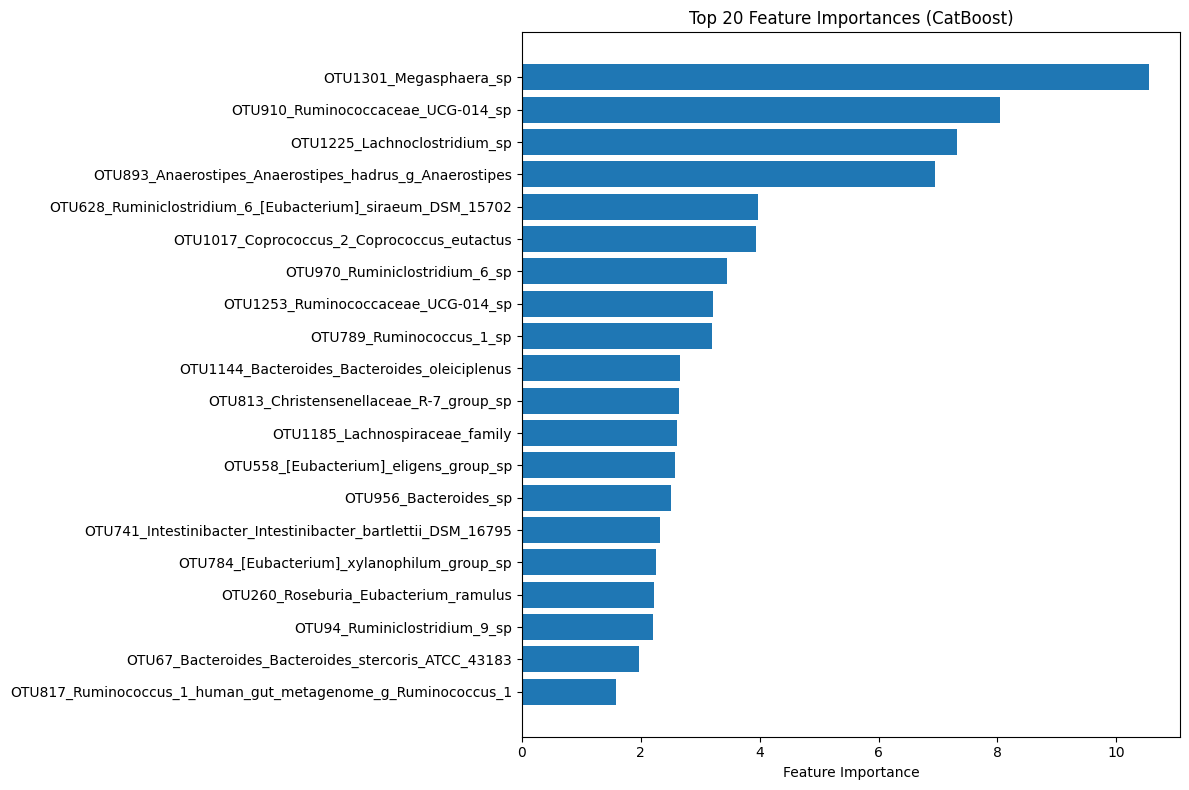


[CV] Cross-Validation Analysis...
CV AUC Scores: [0.98792271 0.93961353 0.93478261 0.91161616 0.96163683]
Mean CV AUC: 0.947 (+/- 0.052)

[PERFORMANCE] Model Performance on Test Set:
              precision    recall  f1-score   support

     Control       0.87      0.59      0.70        22
      Autism       0.75      0.93      0.83        29

    accuracy                           0.78        51
   macro avg       0.81      0.76      0.77        51
weighted avg       0.80      0.78      0.78        51



In [35]:
# Step 7: Model Interpretation and Feature Importance
print("=== Model Interpretation and Feature Importance ===")

if 'best_model' in locals() and 'selected_features' in locals():
    
    # Feature importance analysis
    print(f"\n[ANALYSIS] Analyzing {best_model_name} feature importance...")
    
    try:
        if hasattr(best_model, 'feature_importances_'):
            # Tree-based models (RF, XGB, CatBoost)
            importances = best_model.feature_importances_
        elif hasattr(best_model, 'coef_'):
            # Linear models (LR)
            importances = np.abs(best_model.coef_[0])
        else:
            importances = np.ones(len(selected_features))  # Fallback
        
        # Create feature importance dataframe
        feature_imp_df = pd.DataFrame({
            'feature': selected_features,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("\n[TOP FEATURES] Top 15 Most Important Features:")
        print("=" * 60)
        for i, row in feature_imp_df.head(15).iterrows():
            print(f"{row['feature']:40s} | {row['importance']:.4f}")
        
        # Visualization
        plt.figure(figsize=(12, 8))
        top_features = feature_imp_df.head(20)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'Top 20 Feature Importances ({best_model_name})')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"[WARNING] Feature importance analysis failed: {e}")
    
    # Cross-validation analysis
    print("\n[CV] Cross-Validation Analysis...")
    try:
        cv_scores = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='roc_auc')
        print(f"CV AUC Scores: {cv_scores}")
        print(f"Mean CV AUC: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    except Exception as e:
        print(f"[WARNING] Cross-validation failed: {e}")
    
    # Model predictions summary
    print("\n[PERFORMANCE] Model Performance on Test Set:")
    if best_model_name == 'Random Forest' and 'rf_pred' in locals():
        test_pred = rf_pred
        test_prob = rf_prob
    elif best_model_name == 'CatBoost' and 'cat_pred' in locals():
        test_pred = cat_pred
        test_prob = cat_prob
    elif best_model_name == 'Logistic Regression' and 'lr_pred' in locals():
        test_pred = lr_pred
        test_prob = lr_prob
    else:
        print("[WARNING] No predictions available for detailed report")
    
    if 'test_pred' in locals():
        print(classification_report(y_test, test_pred, target_names=['Control', 'Autism']))
    
else:
    print("[ERROR] Cannot perform interpretation without trained models")


=== Shannon Diversity and Richness Analysis ===
[CALCULATING] Computing Shannon diversity metrics...
[SUCCESS] Calculated Shannon diversity for 254 samples
[INFO] Group sizes: ASD=143, Control=111
[STATISTICAL] Shannon diversity: t=-1.978, p=0.0490


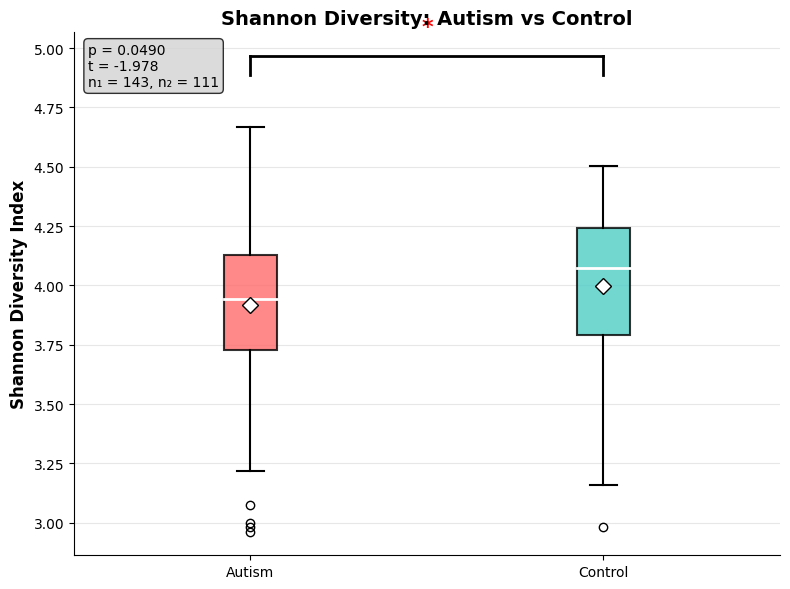


[SUMMARY] SHANNON DIVERSITY ANALYSIS

[RESULTS] Statistical Test Results:
  Autism Group:    3.915 ± 0.319 (n=143)
  Control Group:   3.997 ± 0.332 (n=111)
  T-statistic:     -1.978
  P-value:         0.0490 *
  Interpretation:  SIGNIFICANT difference

[LEGEND] Significance Levels:
  *** p < 0.001   ** p < 0.01   * p < 0.05   ns p >= 0.05
[COMPLETE] Shannon diversity analysis complete!


In [39]:
# Step 7a: Shannon Diversity Analysis with Statistical Testing
print("=== Shannon Diversity and Richness Analysis ===")

if 'X' in locals() and 'y' in locals():
    
    # Calculate Shannon diversity for each sample
    print("[CALCULATING] Computing Shannon diversity metrics...")
    
    # Shannon diversity calculation
    def calculate_shannon_diversity(abundance_row):
        """Calculate Shannon diversity index for a sample"""
        # Remove zero abundances
        abundances = abundance_row[abundance_row > 0]
        if len(abundances) == 0:
            return 0
        
        # Calculate proportions
        proportions = abundances / abundances.sum()
        
        # Shannon diversity: H = -sum(p * log(p))
        shannon = -np.sum(proportions * np.log(proportions))
        return shannon
    
    # Calculate diversity metrics for each sample
    shannon_diversity = X.apply(calculate_shannon_diversity, axis=1)
    
    print(f"[SUCCESS] Calculated Shannon diversity for {len(shannon_diversity)} samples")
    
    # Separate by group (Autism vs Control)
    autism_samples = y == 1
    control_samples = y == 0
    
    asd_shannon = shannon_diversity[autism_samples]
    ctrl_shannon = shannon_diversity[control_samples]
    
    print(f"[INFO] Group sizes: ASD={len(asd_shannon)}, Control={len(ctrl_shannon)}")
    
    # Statistical testing
    from scipy import stats
    
    # Perform t-test for Shannon diversity
    shannon_t_stat, shannon_p_value = stats.ttest_ind(asd_shannon, ctrl_shannon)
    
    print(f"[STATISTICAL] Shannon diversity: t={shannon_t_stat:.3f}, p={shannon_p_value:.4f}")
    
    # Helper function for significance markers
    def get_significance_marker(p_value):
        """Return significance marker based on p-value"""
        if p_value < 0.001:
            return '***'
        elif p_value < 0.01:
            return '**'
        elif p_value < 0.05:
            return '*'
        else:
            return 'ns'
    
    # Create clean Shannon diversity box plot visualization
    plt.figure(figsize=(8, 6))
    
    colors = ['#FF6B6B', '#4ECDC4']
    groups = ['Autism', 'Control']
    
    # Shannon Diversity Box Plot
    box_data = [asd_shannon, ctrl_shannon]
    bp = plt.boxplot(box_data, labels=groups, patch_artist=True, 
                     boxprops=dict(alpha=0.8, linewidth=1.5), 
                     whiskerprops=dict(linewidth=1.5),
                     capprops=dict(linewidth=1.5),
                     medianprops=dict(linewidth=2, color='white'),
                     showmeans=True, 
                     meanprops=dict(marker='D', markerfacecolor='white', markeredgecolor='black', markersize=8))
    
    # Color the boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    plt.ylabel('Shannon Diversity Index', fontweight='bold', fontsize=12)
    plt.title('Shannon Diversity: Autism vs Control', fontweight='bold', fontsize=14)
    
    # Add significance marker
    significance_marker = get_significance_marker(shannon_p_value)
    y_max_box = max([np.max(asd_shannon), np.max(ctrl_shannon)]) + 0.3
    plt.plot([1, 2], [y_max_box, y_max_box], 'k-', linewidth=2)
    plt.plot([1, 1], [y_max_box-0.08, y_max_box], 'k-', linewidth=2)
    plt.plot([2, 2], [y_max_box-0.08, y_max_box], 'k-', linewidth=2)
    plt.text(1.5, y_max_box + 0.08, significance_marker, ha='center', va='bottom', 
             fontweight='bold', fontsize=16, 
             color='red' if shannon_p_value < 0.05 else 'black')
    
    # Add statistical information as text box
    stats_text = f'p = {shannon_p_value:.4f}\nt = {shannon_t_stat:.3f}\nn₁ = {len(asd_shannon)}, n₂ = {len(ctrl_shannon)}'
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8))
    
    # Improve aesthetics
    plt.grid(True, alpha=0.3, axis='y')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical Summary Report
    print("\n" + "="*50)
    print("[SUMMARY] SHANNON DIVERSITY ANALYSIS")
    print("="*50)
    
    print(f"\n[RESULTS] Statistical Test Results:")
    print(f"  Autism Group:    {np.mean(asd_shannon):.3f} ± {np.std(asd_shannon):.3f} (n={len(asd_shannon)})")
    print(f"  Control Group:   {np.mean(ctrl_shannon):.3f} ± {np.std(ctrl_shannon):.3f} (n={len(ctrl_shannon)})")
    print(f"  T-statistic:     {shannon_t_stat:.3f}")
    print(f"  P-value:         {shannon_p_value:.4f} {get_significance_marker(shannon_p_value)}")
    print(f"  Interpretation:  {'SIGNIFICANT difference' if shannon_p_value < 0.05 else 'No significant difference'}")
    
    print(f"\n[LEGEND] Significance Levels:")
    print(f"  *** p < 0.001   ** p < 0.01   * p < 0.05   ns p >= 0.05")
    
    print("="*50)
    print("[COMPLETE] Shannon diversity analysis complete!")
    
else:
    print("[ERROR] Cannot perform diversity analysis without processed microbiome data")


In [37]:
# Step 8: Personalized Healthcare Recommendations
print("=== Personalized Healthcare Recommendations ===")

if 'best_model' in locals() and 'feature_imp_df' in locals():
    
    def generate_personalized_recommendations(sample_features, model, feature_names, top_features_df):
        """Generate personalized recommendations based on model predictions and feature importance"""
        
        # Get prediction and probability
        prediction = model.predict(sample_features.reshape(1, -1))[0]
        prob = model.predict_proba(sample_features.reshape(1, -1))[0]
        
        print(f"\n[PREDICTION] Prediction Analysis:")
        print(f"   Predicted Class: {'Autism Risk' if prediction == 1 else 'Control'}")
        print(f"   Autism Risk Probability: {prob[1]:.3f}")
        print(f"   Control Probability: {prob[0]:.3f}")
        
        # Analyze top contributing features
        print(f"\n[MICROBIOME] Key Microbiome Factors:")
        
        # Get top 10 most important features and their values
        top_10_features = top_features_df.head(10)
        
        for i, (_, row) in enumerate(top_10_features.iterrows()):
            feature_idx = feature_names.index(row['feature']) if row['feature'] in feature_names else -1
            if feature_idx >= 0 and feature_idx < len(sample_features):
                feature_value = sample_features[feature_idx]
                print(f"   {i+1:2d}. {row['feature'][:40]:40s} | Value: {feature_value:.4f} | Importance: {row['importance']:.4f}")
        
        # Generate recommendations
        print(f"\n[RECOMMENDATIONS] Personalized Recommendations:")
        
        if prediction == 1:  # High autism risk
            print("   [HIGH RISK] ELEVATED RISK DETECTED")
            print("   [ACTIONS] Recommended Actions:")
            print("      • Consult with a healthcare professional for comprehensive evaluation")
            print("      • Consider microbiome-targeted interventions (probiotics, dietary changes)")
            print("      • Monitor key bacterial populations identified as significant")
            print("      • Consider functional medicine approach to gut health")
            print("      • Regular follow-up microbiome testing")
        else:  # Low risk
            print("   [LOW RISK] LOW RISK PROFILE")
            print("   [MAINTENANCE] Maintenance Recommendations:")
            print("      • Maintain current healthy microbiome profile")
            print("      • Continue balanced diet rich in fiber and probiotics")
            print("      • Regular exercise and stress management")
            print("      • Periodic microbiome monitoring for prevention")
        
        return prediction, prob
    
    # Example: Generate recommendations for a few test samples
    print("\n[ANALYSIS] Sample Personalized Analysis:")
    print("=" * 60)
    
    # Analyze first 3 test samples
    for i in range(min(3, X_test_selected.shape[0])):
        print(f"\n[SAMPLE] SAMPLE {i+1} ANALYSIS:")
        print("-" * 40)
        
        sample_features = X_test_selected[i]
        actual_label = y_test.iloc[i]
        
        print(f"Actual Label: {'Autism' if actual_label == 1 else 'Control'}")
        
        pred, prob = generate_personalized_recommendations(
            sample_features, best_model, selected_features, feature_imp_df
        )
        
        # Check if prediction matches actual
        correct = "[CORRECT]" if pred == actual_label else "[INCORRECT]"
        print(f"\n   Prediction Accuracy: {correct} {'Correct' if pred == actual_label else 'Incorrect'}")
    
    print("\n" + "="*60)
    print("[COMPLETE] ANALYSIS COMPLETE")
    print(f"[MODEL] Best Model: {best_model_name}")
    print(f"[PERFORMANCE] Model Performance: {results[best_model_name]['accuracy']:.1%} accuracy, {results[best_model_name]['auc']:.3f} AUC")
    print(f"[FEATURES] Features Used: {len(selected_features)} microbiome features")
    print("[READY] Ready for personalized healthcare recommendations!")
    
else:
    print("[ERROR] Cannot generate recommendations without trained model and feature analysis")


=== Personalized Healthcare Recommendations ===

[ANALYSIS] Sample Personalized Analysis:

[SAMPLE] SAMPLE 1 ANALYSIS:
----------------------------------------
Actual Label: Autism

[PREDICTION] Prediction Analysis:
   Predicted Class: Autism Risk
   Autism Risk Probability: 0.986
   Control Probability: 0.014

[MICROBIOME] Key Microbiome Factors:
    1. OTU1301_Megasphaera_sp                   | Value: -0.2742 | Importance: 10.5431
    2. OTU910_Ruminococcaceae_UCG-014_sp        | Value: -0.4271 | Importance: 8.0471
    3. OTU1225_Lachnoclostridium_sp             | Value: 0.0821 | Importance: 7.3251
    4. OTU893_Anaerostipes_Anaerostipes_hadrus_ | Value: -0.6629 | Importance: 6.9527
    5. OTU628_Ruminiclostridium_6_[Eubacterium] | Value: -0.2270 | Importance: 3.9640
    6. OTU1017_Coprococcus_2_Coprococcus_eutact | Value: -0.5642 | Importance: 3.9432
    7. OTU970_Ruminiclostridium_6_sp            | Value: -0.4700 | Importance: 3.4537
    8. OTU1253_Ruminococcaceae_UCG-014_sp       